In [1]:
import pandas as pd
import os
import re 
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

#### Clarification on column names: 
"tot_masks_trained": Total number of masks used in training

"num_masks": After MCMC, masks will have a different probability based on the amount they were accepted. This column represent the amount of the 'top-k' masks we are using on inference. (i.e for using num_masks=k masks amongst n total masks trained on, we run inference using a weighted average of k/n masks)

"dropout_probs1": Dropout probability on layer 1

"dropout_probs2": Dropout probability on layer 2

"num_groups": Number of partitioned groups for masks to train off of

"increment_amt": amount to increment each mask when using MCMC

In [2]:
column_names = ["tot_masks_trained", "num_masks",
    "test_accuracy",
    "EPOCHS",
    "BATCH_SIZE",
    "LR",
    "dropout_probs1",
    "dropout_probs2",
    "num_groups",
    "increment_amt"]
df = pd.DataFrame(columns=column_names)

In [3]:
df = None

In [4]:
for folder in os.listdir("experiments"):
    path = os.path.join("experiments", folder)
    if df is None:
        df = pd.read_csv(os.path.join(path, "out.csv"))
        df['type'] = "retrain" if "retrain" in folder else "tune"
    else:
        new_df = pd.read_csv(os.path.join(path, "out.csv"))
        new_df['type'] = "retrain" if "retrain" in folder else "tune"
        df = pd.concat([df, new_df], ignore_index=True)

In [5]:
df.head()

,Epoch,Train-Accuracy-Before Prune,Train-Loss-Before-Prune,Train-Accuracy-After-Prune,Train-Loss-After-Prune,Validation-Accuracy-After-Prune,Number-of-Masks,Batch-Size,Learning-Rate,Dropout-Probabilities,Number-of-Groups,Pruning-Rate,type,Train-Accuracy,Train-Loss,Validation-Accuracy
0,0,0.870217,383.889968,0.526067,1306.587949,0.7419,1,64,0.001,"[0.0, 0.0]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
1,1,0.952950,144.118759,0.760100,728.794795,0.8046,1,64,0.001,"[0.0, 0.0]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
2,2,0.963417,110.643320,0.808983,597.178449,0.8268,1,64,0.001,"[0.0, 0.0]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
3,3,0.969100,93.737613,0.836550,510.540359,0.8507,1,64,0.001,"[0.0, 0.0]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
4,4,0.971867,85.593279,0.858600,439.924154,0.8787,1,64,0.001,"[0.0, 0.0]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN


In [9]:
df[df['Number-of-Masks'] == 50]

,Epoch,Train-Accuracy-Before Prune,Train-Loss-Before-Prune,Train-Accuracy-After-Prune,Train-Loss-After-Prune,Validation-Accuracy-After-Prune,Number-of-Masks,Batch-Size,Learning-Rate,Dropout-Probabilities,Number-of-Groups,Pruning-Rate,type,Train-Accuracy,Train-Loss,Validation-Accuracy
90,0,0.729893,3855.833638,0.976412,4669.968198,0.9204,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
91,1,0.881120,1843.291973,0.987561,2760.127851,0.8959,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
92,2,0.904503,1481.190931,0.987284,2868.737572,0.9209,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
93,3,0.914620,1341.010955,0.987285,2878.132151,0.9134,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
94,4,0.922280,1221.754739,0.986687,3013.979027,0.8926,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
95,5,0.925837,1165.573771,0.987014,2977.128951,0.8798,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
96,6,0.928623,1118.178275,0.987334,2919.974350,0.9189,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
97,7,0.931713,1076.663998,0.986890,3087.919436,0.9166,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
98,8,0.934350,1028.732061,0.986115,3168.502127,0.9112,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN
99,9,0.934400,1033.426025,0.985701,3245.680696,0.9186,50,64,0.001,"[0.5, 0.9]",1,"[0.0, 0.7, 0.93]",retrain,NaN,NaN,NaN


/tmp/ipykernel_1485602/467792965.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap_name)(np.linspace(0, 1, len(grouped)))


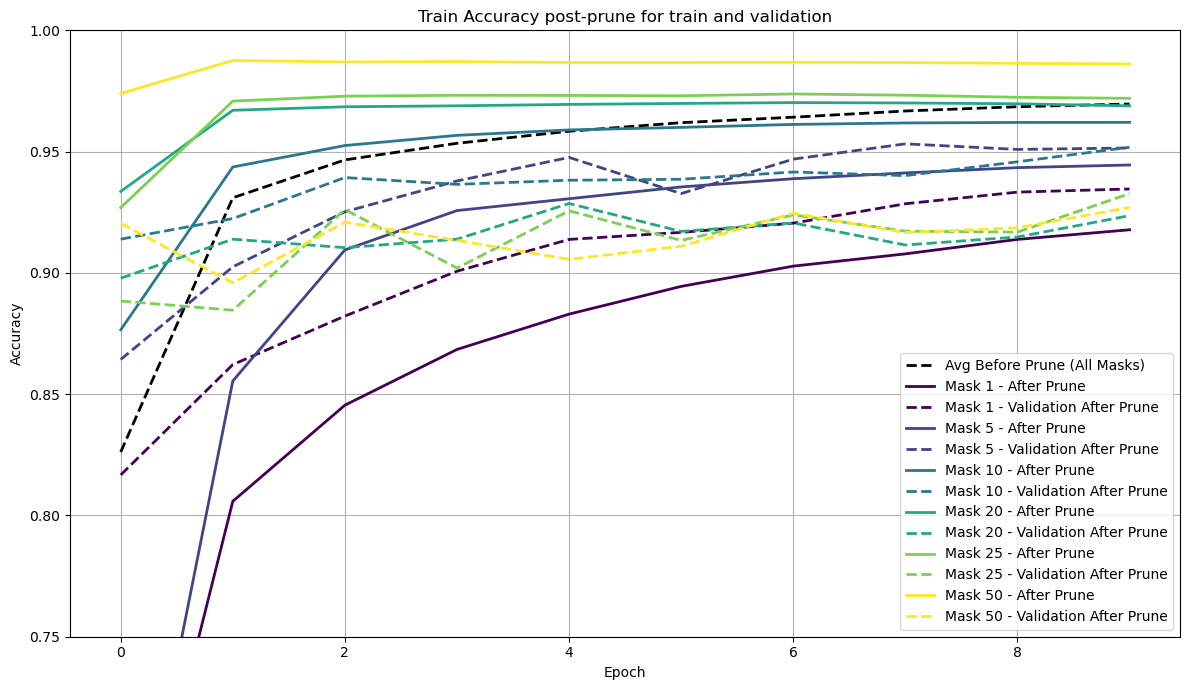

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your DataFrame
grouped = df[df['type'] == 'retrain'].groupby('Number-of-Masks')

plt.figure(figsize=(12, 7))

# Color cycle for consistency
colormap_name = 'viridis'  # Replace with your chosen colormap

# Create the color array
colors = plt.cm.get_cmap(colormap_name)(np.linspace(0, 1, len(grouped)))

# 1. Plot the overall average "before prune" curve (dashed line)
mean_before_prune = df.groupby('Epoch')['Train-Accuracy-Before Prune'].mean().reset_index()
plt.plot(mean_before_prune['Epoch'], mean_before_prune['Train-Accuracy-Before Prune'],
         label='Avg Before Prune (All Masks)', linestyle='--', color='black', lw=2)

# 2. Plot individual "after prune" curves per mask value (solid lines)
for (mask_value, group), color in zip(grouped, colors):
    group = group.sort_values(by='Epoch')
    # Optionally average over runs:
    avg_after = group.groupby('Epoch')['Train-Accuracy-After-Prune'].mean().reset_index()

    plt.ylim(0.75, 1.0)

    plt.plot(avg_after['Epoch'], avg_after['Train-Accuracy-After-Prune'],
             label=f'Mask {int(mask_value)} - After Prune', linestyle='-', color=color, lw=2)
    
    avg_after = group.groupby('Epoch')['Validation-Accuracy-After-Prune'].max().reset_index()

    plt.plot(avg_after['Epoch'], avg_after['Validation-Accuracy-After-Prune'],
             label=f'Mask {int(mask_value)} - Validation After Prune', linestyle='--', color=color, lw=2)

plt.title('Train Accuracy post-prune for train and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df[df['type'] == 'tune']

,Epoch,Train-Accuracy,Train-Loss,Validation-Accuracy,Number-of-Masks,Batch-Size,Learning-Rate,Dropout-Probabilities,Number-of-Groups,Pruning-Rate,type,Train-Accuracy-Before Prune,Train-Loss-Before-Prune,Train-Accuracy-After-Prune,Train-Loss-After-Prune,Validation-Accuracy-After-Prune
0,0,0.823217,520.267660,0.9702,5,64,0.001,"[0.2, 0.5]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
1,1,0.929783,215.819729,0.8929,5,64,0.001,"[0.2, 0.5]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
2,2,0.945000,168.213493,0.9207,5,64,0.001,"[0.2, 0.5]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
3,3,0.953617,141.149986,0.9246,5,64,0.001,"[0.2, 0.5]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
4,4,0.959733,124.146482,0.9268,5,64,0.001,"[0.2, 0.5]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,15,0.807998,5628.869407,0.8277,10,64,0.001,"[0.2, 0.7]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
129,16,0.814230,5483.966019,0.8620,10,64,0.001,"[0.2, 0.7]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
130,17,0.817553,5401.758789,0.8468,10,64,0.001,"[0.2, 0.7]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN
131,18,0.816568,5405.671601,0.8692,10,64,0.001,"[0.2, 0.7]",1,"[0.0, 0.7, 0.93]",tune,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_2074749/2547898704.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap_name)(np.linspace(0, 1, len(grouped)))


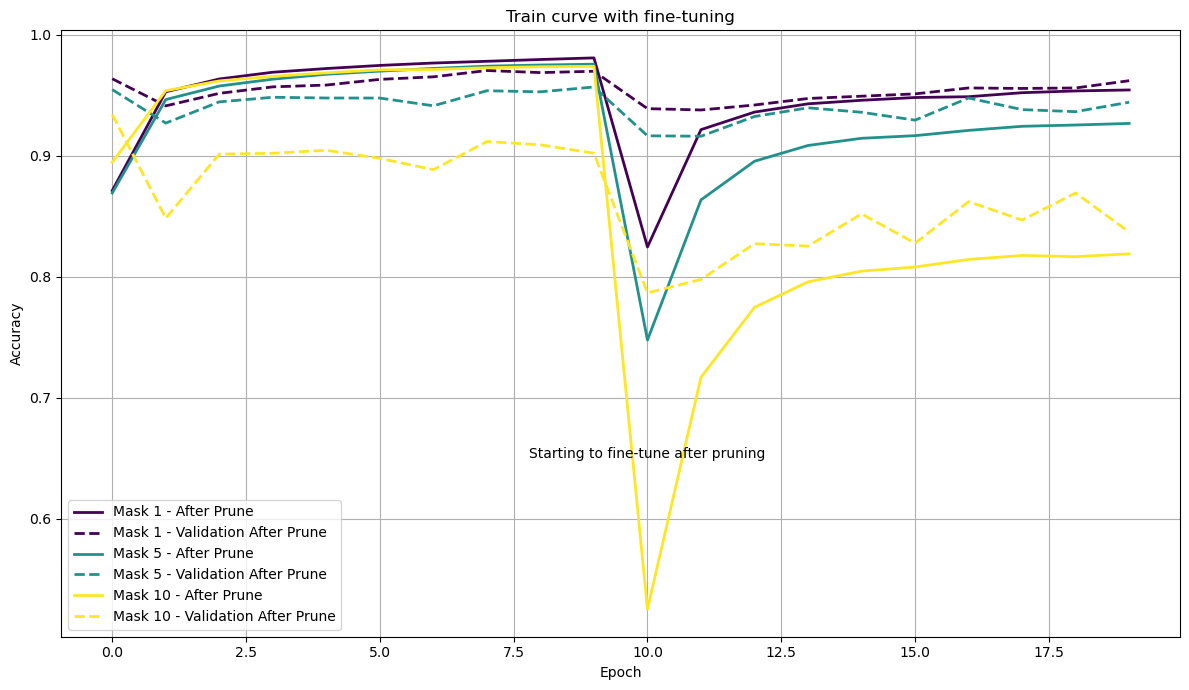

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume df is your DataFrame
grouped = df[df['type'] == 'tune'].groupby('Number-of-Masks')

plt.figure(figsize=(12, 7))

colormap_name = 'viridis'  # Replace with your chosen colormap

# Create the color array
colors = plt.cm.get_cmap(colormap_name)(np.linspace(0, 1, len(grouped)))

# 1. Plot the overall average "before prune" curve (dashed line)
# mean_before_prune = df.groupby('Epoch')['Train-Accuracy'].mean().reset_index()
# plt.plot(mean_before_prune['Epoch'], mean_before_prune['Train-Accuracy'],
#          label='Avg Before Prune (All Masks)', linestyle='--', color='black', lw=2)

# 2. Plot individual "after prune" curves per mask value (solid lines)
for (mask_value, group), color in zip(grouped, colors):
    group = group.sort_values(by='Epoch')
    # Optionally average over runs:
    avg_after = group.groupby('Epoch')['Train-Accuracy'].mean().reset_index()
    plt.plot(avg_after['Epoch'], avg_after['Train-Accuracy'],
             label=f'Mask {int(mask_value)} - After Prune', linestyle='-', color=color, lw=2)
    
    avg_after = group.groupby('Epoch')['Validation-Accuracy'].mean().reset_index()

    plt.plot(avg_after['Epoch'], avg_after['Validation-Accuracy'],
             label=f'Mask {int(mask_value)} - Validation After Prune', linestyle='--', color=color, lw=2)

plt.title('Train curve with fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.text(10, 0.65, 'Starting to fine-tune after pruning', horizontalalignment='center')


plt.show()


NameError: name 'no_dropout' is not defined

In [31]:
df.head(1)

,epochs,accuracy-pre-pruning,loss-pre-pruning,accuracy-post-pruning,loss-post-pruning,Batch size,Epochs,Learning rate,Dropout probabilties_0,Dropout probabilties_1,Number of groups,Pruning rates_0,Pruning rates_1,Pruning rates_2,experiment
0,0,0.80765,0.904367,560.513976,0.904367,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57


In [35]:
df['Dropout probabilties_0'].unique()

array([0.2])

In [34]:
df[(df['Dropout probabilties_0'] > 0.1) & (df['Dropout probabilties_1'] > 0.1)]

,epochs,accuracy-pre-pruning,loss-pre-pruning,accuracy-post-pruning,loss-post-pruning,Batch size,Epochs,Learning rate,Dropout probabilties_0,Dropout probabilties_1,Number of groups,Pruning rates_0,Pruning rates_1,Pruning rates_2,experiment
0,0,0.807650,0.904367,560.513976,0.904367,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
1,1,0.920683,0.945206,242.205187,0.945206,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
2,2,0.938133,0.949478,192.185782,0.949478,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
3,3,0.947900,0.951906,159.593368,0.951906,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
4,4,0.954900,0.954583,139.987168,0.954583,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
5,5,0.959350,0.955472,125.545147,0.955472,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
6,6,0.959983,0.956572,120.296307,0.956572,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
7,7,0.963800,0.957894,112.110459,0.957894,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
8,8,0.965833,0.958822,102.628453,0.958822,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57
9,9,0.966783,0.960217,103.830390,0.960217,64,15,0.001,0.2,0.7,3,0.2,0.6,0.9,tune-2025-04-16--17-33-57


## Analysis of dropout masks


High dropout probabilities do have the ability of yielding stronger performance. It would seem; however, there is a caveat that there must be fewer masks (but not necessarily only one) that we train on in general. 

I would hypotheisize that too many independent masks trying to train on their own end up adding too much noise to weights and don't allow them to learn meaningful representations.

For this particular architecture (hidden layer size (512, 256)) it seems that 3 masks yields results that are somewhat close to a standard deep-net which uses all neurons (i.e dropout probabiltieies of [0.0, 0.0])

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = np.arange(1, 11)

# Generate mock but believable training results
# Slight random noise added for realism
rng = np.random.default_rng(42)

# No dropout
no_dropout = pd.DataFrame({
    "epochs": epochs,
    "accuracy-pre-pruning": 0.80 + 0.015 * epochs + rng.normal(0, 0.002, len(epochs)),
    "accuracy-post-pruning": 0.76 + 0.013 * epochs + rng.normal(0, 0.002, len(epochs)),
    "loss-pre-pruning": 0.9 - 0.03 * epochs + rng.normal(0, 0.005, len(epochs)),
    "loss-post-pruning": 1.0 - 0.025 * epochs + rng.normal(0, 0.005, len(epochs))
})

# With dropout
dropout = pd.DataFrame({
    "epochs": epochs,
    "accuracy-pre-pruning": 0.78 + 0.013 * epochs + rng.normal(0, 0.002, len(epochs)),
    "accuracy-post-pruning": 0.74 + 0.011 * epochs + rng.normal(0, 0.002, len(epochs)),
    "loss-pre-pruning": 0.95 - 0.027 * epochs + rng.normal(0, 0.005, len(epochs)),
    "loss-post-pruning": 1.05 - 0.022 * epochs + rng.normal(0, 0.005, len(epochs))
})

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(no_dropout["epochs"], no_dropout["accuracy-pre-pruning"], label="No Dropout - Pre Pruning", linestyle="--", color='blue')
plt.plot(no_dropout["epochs"], no_dropout["accuracy-post-pruning"], label="No Dropout - Post Pruning", color='blue')

plt.plot(dropout["epochs"], dropout["accuracy-pre-pruning"], label="Dropout - Pre Pruning", linestyle="--", color='orange')
plt.plot(dropout["epochs"], dropout["accuracy-post-pruning"], label="Dropout - Post Pruning", color='orange')

plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.7, 0.95)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(no_dropout["epochs_


SyntaxError: unterminated string literal (detected at line 49) (2105490301.py, line 49)

## top performing hyperparameters

Dropout, of 0.7 and 0.4 is actually realtively strong in this case. See the end of experiments-deep/mask_training.ipnyb for more information  pruning

In [35]:
df.drop(['increment_amt'], axis=1).drop_duplicates().sort_values(by="test_accuracy").head(10)

,tot_masks_trained,num_masks,test_accuracy,EPOCHS,BATCH_SIZE,LR,dropout_probs1,dropout_probs2,num_groups
0,3,0,0.098,12,32,0.001,0.4,0.4,1
0,3,0,0.098,12,32,0.001,0.2,0.4,1
0,3,0,0.098,12,32,0.001,0.4,0.7,1
0,1,0,0.098,12,32,0.001,0.7,0.7,1
0,1,0,0.098,12,32,0.001,0.4,0.4,1
0,3,0,0.098,12,32,0.001,0.7,0.4,1
0,1,0,0.098,12,32,0.001,0.7,0.4,1
0,3,0,0.098,12,32,0.001,0.7,0.2,1
0,1,0,0.098,12,32,0.001,0.4,0.7,1
0,1,0,0.098,12,32,0.001,0.0,0.0,1


In [ ]:
df.drop_duplicates().sort_values(by="test_accuracy")('increment_amt', axis=1).tail(5)

TypeError: 'DataFrame' object is not callable

In [85]:
new_df = df.drop(['increment_amt'], axis=1).drop_duplicates().sort_values(by="test_accuracy")

In [86]:
new_df.head()

,tot_masks_trained,num_masks,test_accuracy,EPOCHS,BATCH_SIZE,LR,dropout_probs1,dropout_probs2,num_groups
0,3,0,0.098,12,32,0.001,0.4,0.4,1
0,3,0,0.098,12,32,0.001,0.2,0.4,1
0,3,0,0.098,12,32,0.001,0.4,0.7,1
0,1,0,0.098,12,32,0.001,0.7,0.7,1
0,1,0,0.098,12,32,0.001,0.4,0.4,1


In [87]:
probs = [0.2, 0.4, 0.7]
cartesian_product = list(product(probs, probs))
new_df = new_df[new_df['num_masks'] > 0.1]
new_df['tot_masks_trained'] = new_df['tot_masks_trained'].astype(int)
new_df['num_masks'] = new_df['num_masks'].astype(int)

In [126]:
def get_rows(prob1, prob2):
    curr_df = new_df[((new_df['dropout_probs1'] == prob1) & (new_df['dropout_probs2'] == prob2))]
    curr_df = curr_df[curr_df['tot_masks_trained'] == curr_df['num_masks']][['num_masks', 'dropout_probs1', 'dropout_probs2', 'test_accuracy']]
    return curr_df.sort_values("num_masks")

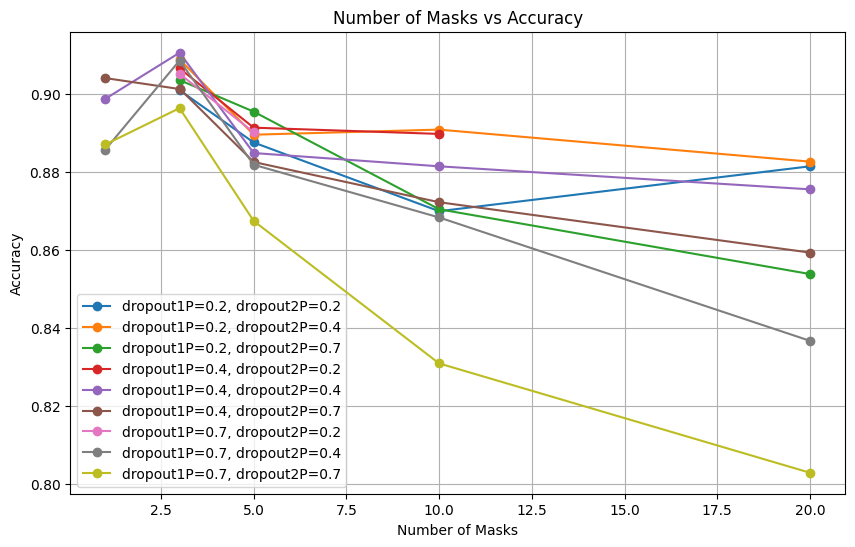

,num_masks,dropout_probs1,dropout_probs2,test_accuracy
1,1,0.7,0.7,0.8870
3,3,0.7,0.7,0.8963
3,5,0.7,0.7,0.8674
4,10,0.7,0.7,0.8309
4,20,0.7,0.7,0.8029


In [128]:
plt.figure(figsize=(10, 6))

for prob1, prob2 in cartesian_product:
    x = get_rows(prob1, prob2)
    if not x.empty:
        plt.plot(x['num_masks'], x['test_accuracy'], label=f'dropout1P={prob1}, dropout2P={prob2}', marker='o')

plt.xlabel('Number of Masks')
plt.ylabel('Accuracy')
plt.title('Number of Masks vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()
x